In [1]:
!wget https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt

--2026-01-04 19:55:30--  https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22322605 (21M) [text/plain]
Saving to: ‘Compiled_Reviews.txt.5’

Compiled_Reviews.tx 100%[===================>]  21.29M  5.88MB/s    in 3.5s    

2026-01-04 19:55:35 (6.04 MB/s) - ‘Compiled_Reviews.txt.5’ saved [22322605/22322605]



In [2]:
reviews=[]
sentiment_ratings=[]
product_types=[]
helpfulness_ratings=[]

with open("Compiled_Reviews.txt") as f:
   for line in f.readlines()[1:]:
        fields = line.rstrip().split('\t')
        reviews.append(fields[0])
        sentiment_ratings.append(fields[1])
        product_types.append(fields[2])
        helpfulness_ratings.append(fields[3])


In [3]:
from collections import Counter
import re
import math
import matplotlib.pyplot as plt
import numpy as np
import os

In [61]:
Counter(helpfulness_ratings)

Counter({'helpful': 20351, 'neutral': 10321, 'unhelpful': 5876})

# Sentiment Classifier Using Logistic Regression


1. Extract 5000 most frequent words as our features for predition and use one-hot encoding to represent the data.
2. Split our data into training and testing sets.
3. Train and Test our classifier with mini-batch training and L2 regularization.





### 1.  Extract 5000 most frequent words as our features for predition and use one-hot encoding to represent the data.




1.1 Extract 5000 most frequent words

In [4]:
from collections import Counter
import re

# getting a list of lists of tokens.
tokenised_reviews = [re.findall(r"\b\w+\b|[!?]+", review.lower()) for review in reviews]

# Collapse all tokens into a single list
tokens=[]
for s in tokenised_reviews:
      tokens.extend(s)
# Count the tokens in the tokens list.
counts=Counter(tokens)

# Sort the tuples in descending order.
so=sorted(counts.items(), key=lambda item: item[1], reverse=True)
# Extract the list of tokens
so=list(zip(*so))[0]
# Select the first 10000 words in the list
type_list=so[0:5000]

1.2 Creating an one-hot encoding matrix

In [5]:
# Create a 36548 x 5000 matrix of zeros
M = np.zeros((len(reviews), len(type_list)))
#iterate over the reviews
for i, tokenised_rev in enumerate(tokenised_reviews):
  for j,word in enumerate(type_list):
    if word in tokenised_rev:
      M[i,j]=1

### 2.Split our data into training, development and testing sets.

In [64]:
#Labeling the train, development and test sets
seed_value = 42  
np.random.seed(seed_value)
train_ints=np.random.choice(len(reviews),int(len(reviews)*0.8),replace=False)
remaining_ints=list(set(range(0,len(reviews))) - set(train_ints))
test_ints=np.random.choice(remaining_ints,int(len(remaining_ints)*0.5),replace=False)
dev_ints=list(set(remaining_ints) - set(test_ints))



In [65]:
# Generate one-hot encoded input matrices for training, development and test
M_train = np.array(M[train_ints,])
M_test = np.array(M[test_ints,])
M_dev = np.array(M[dev_ints,])

sents_train = [sentiment_ratings[i] for i in train_ints]
sents_test = [sentiment_ratings[i] for i in test_ints]
sents_dev = [sentiment_ratings[i] for i in dev_ints]



### 3. Train and Test Our Classifier with Mini Batching and L2 Regularization

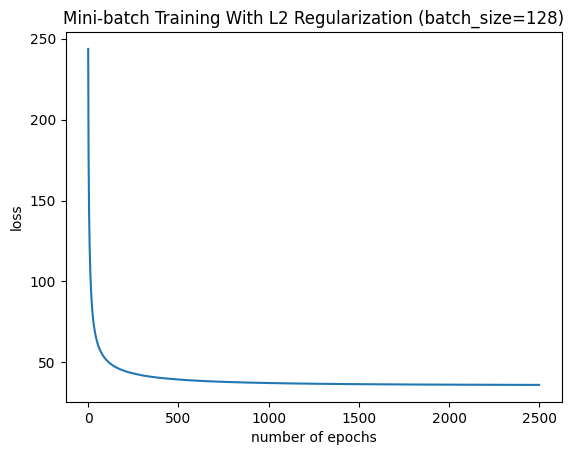

In [9]:
np.random.seed(seed_value)
num_features=5000
y = np.array([int(l == "positive") for l in sents_train])
weights = np.random.rand(num_features)
bias=np.random.rand(1)
n_iters = 2500
lr=0.1
logistic_loss=[]
lambda_l2=0.001
num_samples=len(y)



batch_size=128
n_batches= num_samples//batch_size
if num_samples%batch_size !=0:
   n_batches += 1

for i in range(n_iters):
    shuffled_indices = np.random.permutation(num_samples)
    total_batch_loss=0


    for batch_n in range(n_batches):
       
       start_index=batch_size*batch_n
       end_index=min((batch_size)*(batch_n+1), num_samples)

       batch_indices = shuffled_indices[start_index:end_index]
       M_train_batch = M_train[batch_indices, :]
       y_train_batch = y[batch_indices]
       batch_samples=len(y_train_batch)

       z=M_train_batch.dot(weights)+bias 
       q=1/(1+np.exp(-z))
       eps=0.00001
       Cross_Entropy_Loss = -sum((y_train_batch*np.log2(q+eps)+(np.ones(len(y_train_batch))-y_train_batch)*np.log2(np.ones(len(y_train_batch))-q+eps)))
       l2_penalty = lambda_l2 * np.sum(weights**2)
       batch_loss=Cross_Entropy_Loss + l2_penalty
       total_batch_loss += batch_loss
  

       dw = (q-y_train_batch).dot(M_train_batch)/batch_samples
       dw = dw + (2 * lambda_l2 * weights) / batch_samples
       db = sum(q-y_train_batch)/batch_samples
       weights = weights-lr*dw
       bias = bias-lr*db

    epoch_loss = total_batch_loss / n_batches
    logistic_loss.append(epoch_loss)

plt.plot(range(1, n_iters), logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title(f"Mini-batch Training With L2 Regularization (batch_size={batch_size})")
plt.show()

In [ ]:
#Testing
z_test= M_test.dot(weights)+bias
q_test = 1/(1+np.exp(-z_test))
y_test_pred=[int(ql > 0.5) for ql in q_test]
sents_test_pred=["positive" if s == 1 else "negative" for s in y_test_pred]

TP = sum([int(yp == "positive" and sents_test[s] == "positive") for s, yp in enumerate(sents_test_pred)])
FP = sum([int(yp == "positive" and sents_test[s] == "negative") for s, yp in enumerate(sents_test_pred)])  
FN = sum([int(yp == "negative" and sents_test[s] == "positive") for s, yp in enumerate(sents_test_pred)])  
TN = sum([int(yp == "negative" and sents_test[s] == "negative") for s, yp in enumerate(sents_test_pred)])

total = len(sents_test)
accuracy = (TP + TN) / total  # 正确计算 accuracy
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Total samples: {total}")
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Total samples: 3655
TP: 1867, FP: 278, FN: 254, TN: 1256
Accuracy: 0.8544
Precision: 0.8704
Recall: 0.8802
F1 Score: 0.8753


# Helpfulness Classifier Using Multi-nomial Logistic Regression


1. One-hot encode and resplit the data for a multi-classify problem.
2. Train and test the helpfulness classifier with mini-batch training and L2 regulation.
3. Using Weighted Cross Entropy Loss.


### 1. One-hot encode and resplit the data for a multi-classify problem.

In [85]:
np.random.seed(seed_value)
train_ints=np.random.choice(len(reviews),int(len(reviews)*0.8),replace=False)
remaining_ints=list(set(range(0,len(reviews))) - set(train_ints))
test_ints=np.random.choice(remaining_ints,int(len(remaining_ints)*0.5),replace=False)
dev_ints=list(set(remaining_ints) - set(test_ints))

In [86]:
# Generate one-hot encoded input matrices for training, development and test
M_train = np.array(M[train_ints,])
M_test = np.array(M[test_ints,])
M_dev = np.array(M[dev_ints,])

unique_labels=list(set(helpfulness_ratings))
unique_one_hot=np.diag(np.ones(len(unique_labels)))

helpfulness_train = [helpfulness_ratings[i] for i in train_ints]
helpfulness_test = [helpfulness_ratings[i] for i in test_ints]
helpfulness_dev = [helpfulness_ratings[i] for i in dev_ints]

y_train=np.array(list(unique_one_hot[k] for k in [unique_labels.index(x) for x in helpfulness_train]))
y_test=np.array(list(unique_one_hot[k] for k in [unique_labels.index(x) for x in helpfulness_test]))
y_dev=np.array(list(unique_one_hot[k] for k in [unique_labels.index(x) for x in helpfulness_dev]))



### 2.Train and test the helpfulness classifier with mini-batch training and L2 regulation.

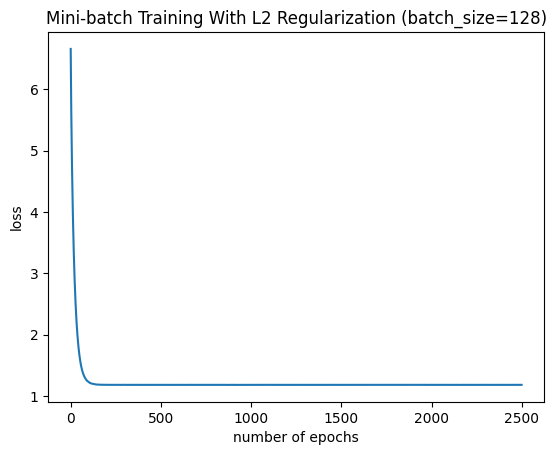

In [51]:
np.random.seed(seed_value)
n_iters = 2500
num_features=5000
num_classes=3
num_samples = len(y_train)
weights = np.random.rand(num_classes,num_features)
bias = np.random.rand(num_classes, 1)
lr=0.05
lambda_l2=0.001
logistic_loss=[]
z=np.zeros((num_samples,num_classes))
q=np.zeros((num_samples,num_classes))

batch_size=128
n_batches= num_samples//batch_size
if num_samples%batch_size !=0:
   n_batches += 1

for i in range(n_iters):
    shuffled_indices = np.random.permutation(num_samples)
    total_batch_loss=0

    for batch_n in range(n_batches):
       
       start_index=batch_size*batch_n
       end_index=min((batch_size)*(batch_n+1), num_samples)

       batch_indices = shuffled_indices[start_index:end_index]
       M_train_batch = M_train[batch_indices, :]
       y_train_batch = y_train[batch_indices, :]
       batch_samples=len(y_train_batch)

       z= M_train_batch.dot(weights.T)+bias.T #(128,3)
       z_sum=np.exp(z).sum(axis=1)
       q=np.array([list(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)]) #(128,3)
       l2_penalty = lambda_l2 * np.sum(weights**2)
       Cross_Entropy_loss=np.mean(-np.log2((np.sum((y_train_batch*q),axis=1)))) #（128，）
       batch_loss = Cross_Entropy_loss + l2_penalty
       total_batch_loss += batch_loss
      
       dw=(q.T-y_train_batch.T).dot(M_train_batch)/batch_samples + 2 * lambda_l2 * weights #(3,128)*(128,12000)=(3,12000)
       db = (q.T - y_train_batch.T).sum(axis=1, keepdims=True) / batch_samples
       weights=(weights - (dw*lr))
       bias = bias - (db * lr)
       
    epoch_loss = total_batch_loss / n_batches
    logistic_loss.append(epoch_loss)
    

plt.plot(range(1, n_iters), logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title(f"Mini-batch Training With L2 Regularization (batch_size={batch_size})")
plt.show()

In [ ]:
#Testing
def evaluate_multicalss_model(M_test, weights, num_classes=3):
    z_test= M_test.dot(weights.T)+bias.T
    z_sum=np.exp(z_test).sum(axis=1)
    q_test = np.array([list(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z_test)]) #(,3)
    y_test_pred=np.argmax(q_test,axis=1)
    y_test_true=np.argmax(y_test,axis=1)
    TP, FP, FN, TN = [], [], [], []
    
    for j in range(num_classes):
        TP.append(np.sum(np.array([int(s == j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))
        FP.append(np.sum(np.array([int(s == j and y_test_true[i] != j) for i,s in enumerate(y_test_pred)])))
        FN.append(np.sum(np.array([int(s != j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))
        TN.append(np.sum(np.array([int(s != j and y_test_true[i] != j) for i,s in enumerate(y_test_pred)])))
    
    TP = [int(x) for x in TP]
    FP = [int(x) for x in FP]
    FN = [int(x) for x in FN]
    TN = [int(x) for x in TN]
    
    total = len(y_test)
    Accuracy = sum(TP)/ total
    PRECISION_by_class=np.array(TP)/(np.array(TP)+np.array(FP)) #逐元素相加相除
    RECALL_by_class=np.array(TP)/(np.array(TP)+np.array(FN))


#Macroaverage
    PRECISION_macov=np.mean(PRECISION_by_class)
    RECALL_macov=np.mean(RECALL_by_class)
    f1 = 2 * (PRECISION_macov * RECALL_macov) / (PRECISION_macov + RECALL_macov) 
    return (f"Total samples: {total} \n" 
            f"Accuracy: {Accuracy}\n" 
            f"TP: {TP}\n"
            f"FP: {FP}\n"
            f"FN: {FN}\n"
            f"TN: {TN}\n"
            f"Precision by class: {PRECISION_by_class}\n"
            f"Recall by class: {RECALL_by_class}\n"
            f"MACRO Precision: {PRECISION_macov}"
            f"MACRO Recall: {RECALL_macov}"
            f"MACRO F1 Score: {f1:.4f}\n")


In [ ]:
#Testing
results=evaluate_multicalss_model(M_test, weights, num_classes=3)
print(results)

Total samples: 3655
Accuracy: 0.5794801641586868
TP: [304, 1687, 127]
FP: [368, 1041, 128]
FN: [744, 323, 470]
TN: [2239, 604, 2930]
Precision by class: [0.45238095 0.61840176 0.49803922]
Recall by class: [0.29007634 0.83930348 0.21273032]
MACRO Precision: 0.5229406425326729
MACRO Recall: 0.4473700455742946
MACRO F1 Score: 0.4822


### 3.Using Weighted Cross-Entropy Loss

In [87]:
# Checking the Balance of Training Data
class_counts = np.sum(y_train, axis=0)  
num_samples=len(y_train)
class_weights = num_samples / (num_classes * class_counts)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: [ 8224. 16307.  4707.]
Class weights: [1.18506809 0.59765745 2.07053325]


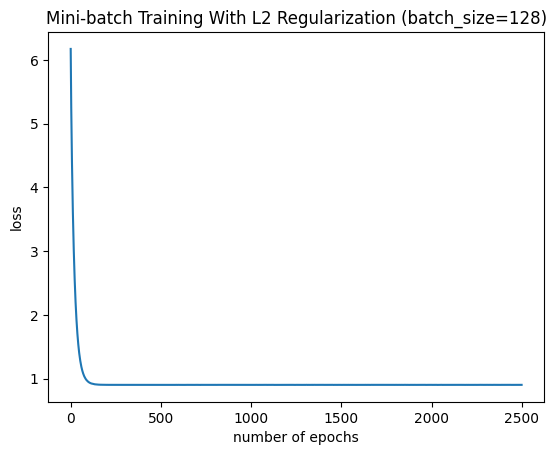

In [88]:
np.random.seed(seed_value)
n_iters = 2500
num_features=5000
num_classes=3
num_samples = len(y_train)
weights = np.random.rand(num_classes,num_features)
bias = np.random.rand(num_classes, 1)
lr=0.05
lambda_l2=0.001
logistic_loss=[]
z=np.zeros((num_samples,num_classes))
q=np.zeros((num_samples,num_classes))

batch_size=128
n_batches= num_samples//batch_size
if num_samples%batch_size !=0:
   n_batches += 1



for i in range(n_iters):
    shuffled_indices = np.random.permutation(num_samples)
    total_batch_loss=0

    for batch_n in range(n_batches):
       
       start_index=batch_size*batch_n
       end_index=min(start_index + batch_size, num_samples)

       batch_indices = shuffled_indices[start_index:end_index]
       M_train_batch = M_train[batch_indices, :]
       y_train_batch = y_train[batch_indices, :] 
       batch_samples=len(y_train_batch)

       # getting sample weights in the current batch
       true_class_indices = np.argmax(y_train_batch, axis=1) 
       sample_weights = class_weights[true_class_indices] 
       sample_weights = sample_weights.reshape(-1, 1) 

       z = M_train_batch.dot(weights.T) + bias.T 
       exp_z = np.exp(z)
       q = exp_z / np.sum(exp_z, axis=1, keepdims=True) 

       l2_penalty = lambda_l2 * np.sum(weights**2)
       
       # Weighted Cross Etropy Loss
       correct_class_probs = np.sum(y_train_batch * q, axis=1) 
       epsilon = 1e-8 
       per_sample_loss = -np.log(correct_class_probs + epsilon) 
       weighted_per_sample_loss = per_sample_loss * sample_weights.flatten()
       Cross_Entropy_loss = np.mean(weighted_per_sample_loss)
       
       batch_loss = Cross_Entropy_loss + l2_penalty
       total_batch_loss += batch_loss
      
      # Weighted Back Propagation
       error = q - y_train_batch
       weighted_error = error * sample_weights 
       
       dw = weighted_error.T.dot(M_train_batch) / batch_samples + 2 * lambda_l2 * weights
       db = np.sum(weighted_error, axis=0, keepdims=True).T / batch_samples # (3, 1)
       
       weights = weights - (dw * lr)
       bias = bias - (db * lr)
       
    epoch_loss = total_batch_loss / n_batches
    logistic_loss.append(epoch_loss)
    

plt.plot(range(1, n_iters), logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title(f"Mini-batch Training With L2 Regularization (batch_size={batch_size})")
plt.show()

In [89]:
#Testing
results=evaluate_multicalss_model(M_test, weights, num_classes=3)
print(results)

Total samples: 3655 
Accuracy: 0.4875512995896033
TP: [546, 905, 331]
FP: [822, 361, 690]
FN: [502, 1105, 266]
TN: [1785, 1284, 2368]
Precision by class: [0.39912281 0.71484992 0.32419197]
Recall by class: [0.52099237 0.45024876 0.55443886]
MACRO Precision: 0.47938823222892685MACRO Recall: 0.5085599945342145MACRO F1 Score: 0.4935



##